# temporal analysis of sst

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
ccrs_proj = ccrs.PlateCarree()

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots


In [2]:
#cluster
import datetime
import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

In [3]:
## Start cluster

!echo $HOSTNAME

mlogin103


In [4]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "200GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [5]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [6]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=200G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/u/u241317/PostProc0x8ylvzr
#SBATCH --begin=now
#SBATCH --output=/scratch/u/u241317/PostProc0x8ylvzr/LOG_cluster.%j.o
#SBATCH --output=/scratch/u/u241317/PostProc0x8ylvzr/LOG_cluster.%j.o

/work/mh0033/u241317/miniconda3/envs/pyicon_py38/bin/python -m distributed.cli.dask_worker tcp://10.50.32.32:38314 --nthreads 4 --nprocs 6 --memory-limit 33.33GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/u/u241317/PostProc0x8ylvzr --interface ib0 --protocol tcp://



In [7]:
cluster.scale(jobs=2)
cluster

In [15]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          34616672       gpu PostProc  u241317 PD       0:00      1 (None)
          34616673       gpu PostProc  u241317 PD       0:00      1 (None)


In [16]:
client = Client(cluster)
client

<Client: 'tcp://10.50.32.32:38314' processes=0 threads=0, memory=0 B>

In [17]:
run      = 'ngSMT_tke'
gname = 'smt'
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'

path_grid        = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree     = f'{path_grid}ckdtree/'
fpath_ckdtree    = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

month = '01'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
search_str = f'_T_S_sp_001-016_2010*.nc' 
flist1      = np.array(glob.glob(path_data+search_str))
flist1.sort()
month = '02'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
search_str = f'_T_S_sp_001-016_2010*.nc' 
flist2      = np.array(glob.glob(path_data+search_str))
flist2.sort()
month = '03'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
search_str = f'_T_S_sp_001-016_2010*.nc' 
flist3      = np.array(glob.glob(path_data+search_str))
flist3.sort()

flist = [*flist1, *flist2, *flist3]
flist.sort()

In [18]:
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [19]:
time0 = np.datetime64('2010-01-09T01:00:00')
dti = pd.date_range(time0, periods=984, freq="2h")
smt = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1))
smt = smt.assign_coords(time=dti)
smt = smt.assign_coords({"clon": ("ncells", clon)})
smt = smt.assign_coords({"clat": ("ncells", clat)})

In [20]:
smt

<xarray.Dataset>
Dimensions:  (time: 984, ncells: 59799625)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
    clon     (ncells) float64 -54.21 -54.22 -54.22 ... -71.82 -71.8 -71.82
    clat     (ncells) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: ncells
Data variables: (12/32)
    T001_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S001_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T002_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S002_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T003_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S003_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    ...       ...
    T014_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S014_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T015_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S015_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T016_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S016_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20180 (Linux 2.6....

In [18]:
lon = -70
lat = 31.9
ic = np.argmin((smt.clon.data-lon)**2 + (smt.clat.data-lat)**2)

NameError: name 'smt' is not defined

In [24]:
npoints = 4000

sname         = 'A'
tgname        = 'SMT'
gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
fname_tgrid   = f'{gname}.nc'
path_scratch  = f'/scratch/u/u241317/tmp/'
path_ckdtree  = path_scratch # where grid is stored

lon = -80.5, -48
lat = 31.9, 31.9

dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lon[1],lat[0]], p2=[lon[0],lat[0]], npoints=npoints,
                      fname_tgrid  = fname_tgrid,
                      path_tgrid   = path_tgrid,
                      path_ckdtree = path_ckdtree,
                      sname = sname,
                      gname = gname,
                      tgname = tgname,
                      load_egrid=False,
                      load_vgrid=False,
                      )

Saving grid file: /scratch/u/u241317/tmp/SMT_nps4000_48W31.9N_80.5W31.9N.npz


In [29]:
smt_sec = smt.isel(ncells=ickdtree)
smt_sec = smt_sec.assign_coords({"clon": ("ncells", lon_sec)})
smt_sec = smt_sec.T001_sp
smt_sec

<xarray.DataArray 'T001_sp' (time: 984, ncells: 4000)>
dask.array<getitem, shape=(984, 4000), dtype=float32, chunksize=(1, 4000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
    clon     (ncells) float64 -48.0 -48.01 -48.02 -48.02 ... -80.48 -80.49 -80.5
    clat     (ncells) float64 31.9 31.9 31.9 31.9 31.9 ... 31.9 31.9 31.9 31.9
Dimensions without coordinates: ncells
Attributes:
    standard_name:                temperature at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [30]:
smt_sec = smt_sec.compute()
smt_sec.to_netcdf('data/smt_sec')

In [32]:
smt_sec = xr.open_dataset('data/smt_sec')

In [33]:
smt_sec

<xarray.Dataset>
Dimensions:  (time: 984, ncells: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
    clon     (ncells) float64 ...
    clat     (ncells) float64 ...
Dimensions without coordinates: ncells
Data variables:
    T001_sp  (time, ncells) float32 ...

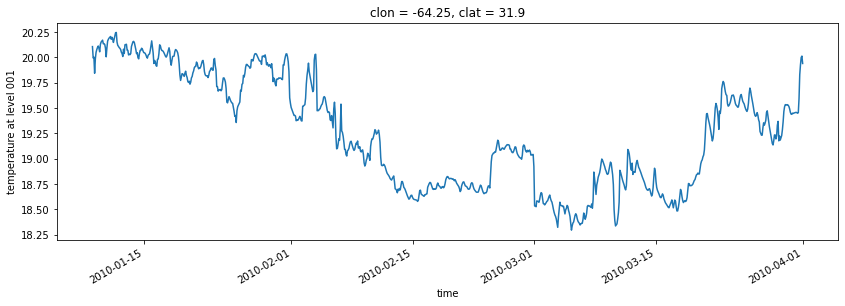

In [7]:
smt_sec.T001_sp.isel(ncells=2500).plot(figsize=(14,4))
plt.savefig('../images/time_series')

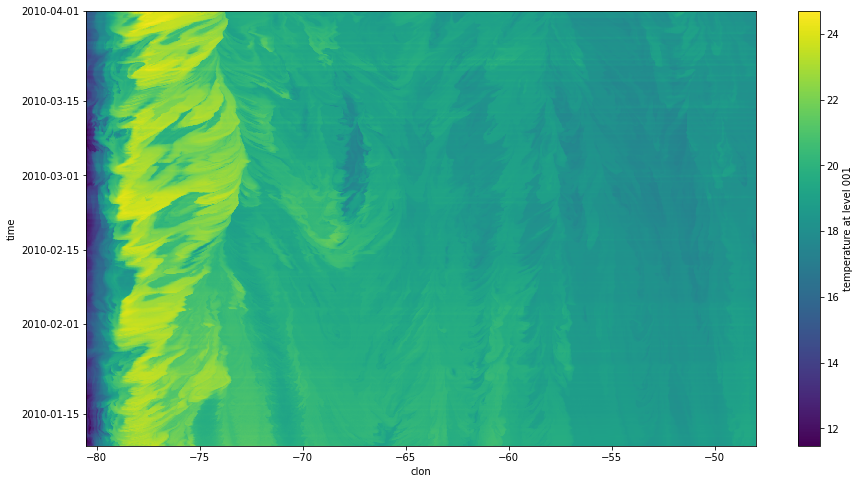

In [23]:
smt_sec.T001_sp.plot(x='clon', y='time', figsize=(15,8))

## FFT of sst timeseries

In [22]:
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import spectrum

#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 

### test

164.0


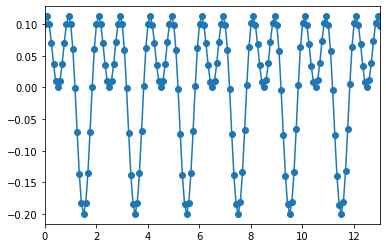

In [117]:
# sin and cosine
N = 2*984
T = N/12
A = 1e-1

x = np.linspace(0, T, N)
x1 = np.linspace(0, T/2 , N)
y = A*np.sin(x1*2*np.pi) + A*np.cos(x*2*np.pi)
plt.plot(x, y, marker='o')
plt.xlim([0,13])
print(T)

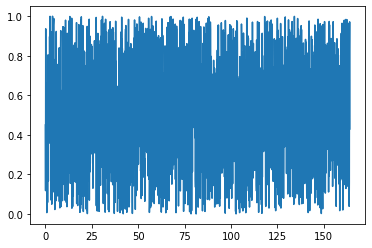

In [120]:
# noise
N = 2*984
x = np.linspace(0, T, N)
rand = np.random.rand(N)
noise = rand/np.max(noise)
plt.plot(x,noise)

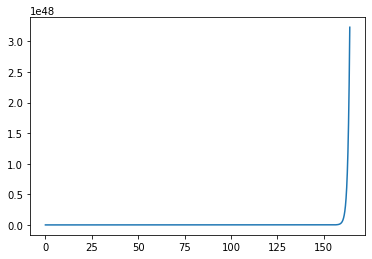

In [134]:
# gaussian
window = signal.gaussian(51, std=7)
#bins = 10#
#mu = # mean
#sigma = 
N = 2*984
x = np.linspace(0, T, N)
g = A*np.exp(x-50)  #= 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )
plt.plot(x,g)

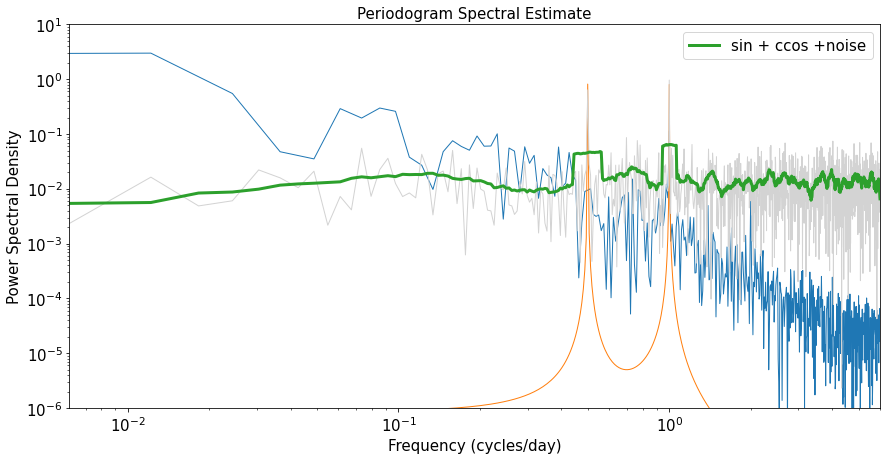

In [123]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
#N = 5000
dt_smt = 2/24

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

cv = smt_sec.T001_sp.isel(ncells=200)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1)

cv = y
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1)

#cv = noise
#f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
#ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1)

cv = y+noise
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color='lightgrey')
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label="sin(1/2D) + cos(1D) +noise")

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e-6, 1e1)
fig.tight_layout()

plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/day)', fontsize=15)
plt.ylabel('Power Spectral Density',fontsize=15)
plt.title('Periodogram Spectral Estimate',fontsize=15);
#plt.savefig('../images/fft_sst_time', bbox_inches='tight')

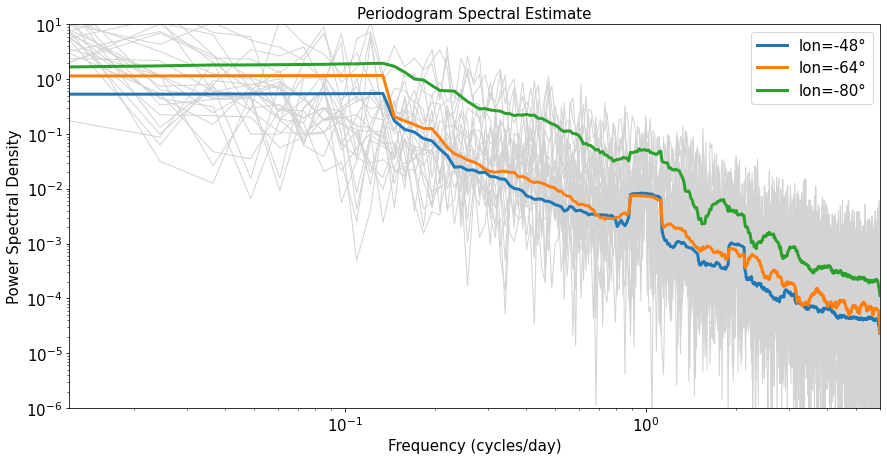

In [9]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
N = 5000
dt_smt = 2/24

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i in np.arange(N)[0::200]:
    cv = smt_sec.T001_sp.isel(ncells=i)
    f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
    ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1,  color='lightgrey')

#smoothed
cv = smt_sec.T001_sp.isel(ncells=10)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
S = S.squeeze()
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label="lon=-48°")

cv = smt_sec.T001_sp.isel(ncells=2500)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
S = S.squeeze()
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label="lon=-64°")

cv = smt_sec.T001_sp.isel(ncells=4950)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
S = S.squeeze()
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label="lon=-80°")

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e-6, 1e1)
fig.tight_layout()

plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/day)', fontsize=15)
plt.ylabel('Power Spectral Density',fontsize=15)
plt.title('Periodogram Spectral Estimate',fontsize=15);
#plt.savefig('../images/fft_sst_time', bbox_inches='tight')

In [41]:
smt_sec.clon.isel(ncells=1500).data

array(-60.19054764)

In [47]:
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Args: 
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24;

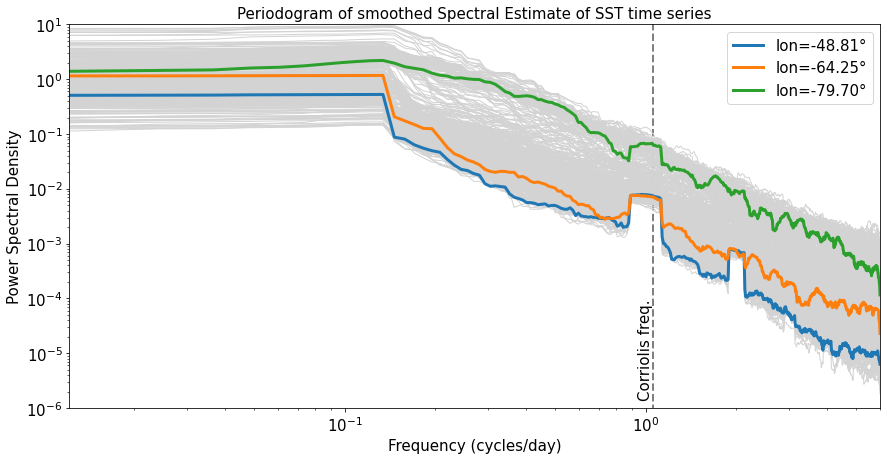

In [56]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
N = 4000
dt_smt = 2/24

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i in np.arange(N)[0::10]:
    cv = smt_sec.T001_sp.isel(ncells=i)
    f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
    S = S.squeeze()
    S = np.convolve(S, kernel, mode='same')
    ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1,  color='lightgrey')

#smoothed

lon_mid = smt_sec.clon.isel(ncells=100).data
cv = smt_sec.T001_sp.isel(ncells=100)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
S = S.squeeze()
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label=f"lon={lon_mid:.2f}°")

lon_mid = smt_sec.clon.isel(ncells=2000).data
cv = smt_sec.T001_sp.isel(ncells=2000)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
S = S.squeeze()
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label=f"lon={lon_mid:.2f}°")

lon_mid = smt_sec.clon.isel(ncells=3900).data
cv = smt_sec.T001_sp.isel(ncells=3900)
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
S = S.squeeze()
S = np.convolve(S, kernel, mode='same')
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=3,  label=f"lon={lon_mid:.2f}°")

ax.vlines(corfreq(31.9)/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--", color="gray",linewidth=2)
ax.text(corfreq(31.9)/2/np.pi, 1e-4, 'Corriolis freq.', ha='right', va='top',rotation='vertical', fontsize=15)



ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e-6, 1e1)
fig.tight_layout()

plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/day)', fontsize=15)
plt.ylabel('Power Spectral Density',fontsize=15)
plt.title('Periodogram of smoothed Spectral Estimate of SST time series',fontsize=15);
plt.savefig('../images/fft_sst_time', bbox_inches='tight')

In [50]:
corfreq(31.9)/2/np.pi

1.0597703084559413

In [ ]:
import matplotlib

In [56]:
# loop for spectra over section with const latitude
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
N = 5000
dt_smt = 2/24
sp = np.zeros((smt_sec.clon.size,  493))
for i in np.arange(N):
    cv = smt_sec.T001_sp.isel(ncells=i)
    f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
    sp[i,:] = S

x = smt_sec.clon
y = f
xx, yy = np.meshgrid(x, y)

<ipython-input-63-f5c65119d102>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(xx, yy, sp[:,:f.size].transpose(),norm=matplotlib.colors.LogNorm(vmin=1e-8, vmax=1e0), cmap='Spectral_r')


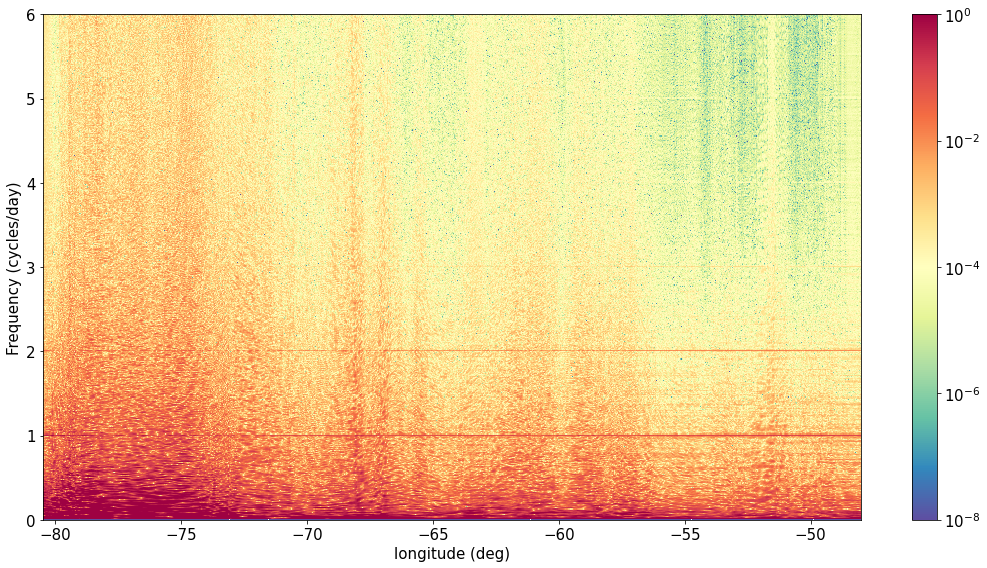

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
im = ax.pcolormesh(xx, yy, sp[:,:f.size].transpose(),norm=matplotlib.colors.LogNorm(vmin=1e-8, vmax=1e0), cmap='Spectral_r')

cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=15) 
ax.tick_params(labelsize=15)
plt.xlabel('longitude (deg)',fontsize=15)
plt.ylabel('Frequency (cycles/day)',fontsize=15)
fig.tight_layout()
plt.savefig('../images/sst_frequency_vs_lon', bbox_inches='tight')

In [66]:
# loop for spectra over section with const latitude
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
N = 5000
dt_smt = 2/24
sp = np.zeros((smt_sec.clon.size,  493))
for i in np.arange(N):
    cv = smt_sec.T001_sp.isel(ncells=i)
    f, S = sg.periodogram(cv-np.mean(cv), fs=1/dt_smt)
    S = S.squeeze()
    S = np.convolve(S, kernel, mode='same')
    sp[i,:] = S

x = smt_sec.clon
y = f
xx, yy = np.meshgrid(x, y)

<ipython-input-67-f7f793cadca0>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(xx, yy, sp[:,:f.size].transpose(),norm=matplotlib.colors.LogNorm(vmin=1e-8, vmax=1e0), cmap='Spectral_r')


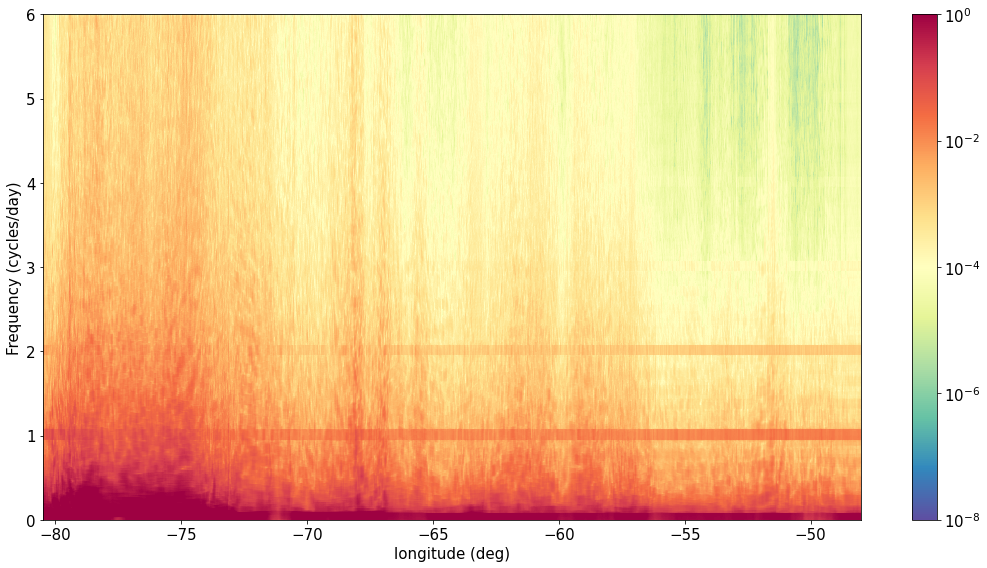

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
im = ax.pcolormesh(xx, yy, sp[:,:f.size].transpose(),norm=matplotlib.colors.LogNorm(vmin=1e-8, vmax=1e0), cmap='Spectral_r')

cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=15) 
ax.tick_params(labelsize=15)
plt.xlabel('longitude (deg)',fontsize=15)
plt.ylabel('Frequency (cycles/day)',fontsize=15)
fig.tight_layout()
plt.savefig('../images/sst_frequency_vs_lon_smoothed', bbox_inches='tight')

(493,)

In [57]:
client.close()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
